# OperationHubをAWSに構築

----

開発用に Amazon&nbsp;EC2インスタンスを確保します。 VPCなどのリソースを合わせて確保するため、CloudFormationを使用しています。


本Notebookでは、以下のようなVPC, Subnet, VMを構築します。

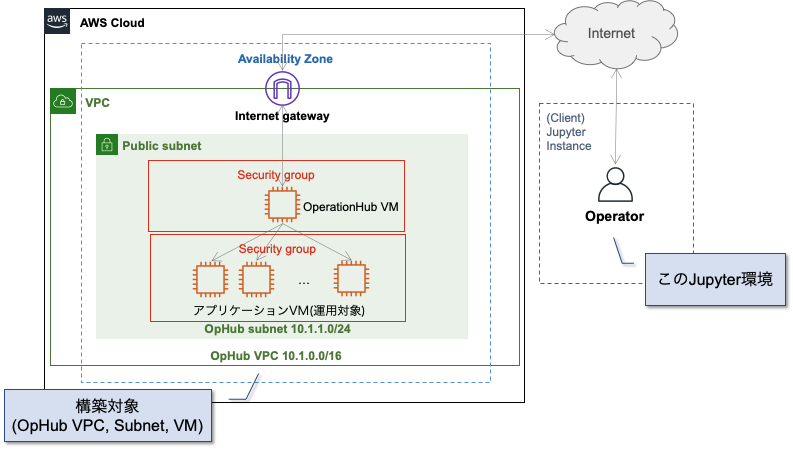

* 本Notebookを試すには、AWSのアカウントが必要です。AWSにてクレジットカード等の登録が必要な場合があります。
* t2.mediumインスタンス(2 vCPU, RAM 4GB)を使用します。使用にはAWSの料金がかかります。料金等はあらかじめ https://aws.amazon.com/jp/ec2/instance-types/t2/ で確認の上、ご自身の責任でお試しください。

# 事前条件

**事前にTerminalから、 `aws configure` を実施してください。**

`aws configure` の実施例:

```
$ aws configure
AWS Access Key ID [None]: (自身のアカウントのアクセスキー)
AWS Secret Access Key [None]: (自身のアカウントのシークレットアクセスキー)
Default region name [None]: ap-northeast-1 (使用したいリージョン)
Default output format [None]: json (jsonを指定)
```

アクセスキー管理方法は様々ありますが、AWS IAMのユーザー https://console.aws.amazon.com/iam/home?region=us-west-2#/users からNotebook用のユーザーを作成する方法があります。万が一アクセスキーが漏れた場合に備えて、権限を最小限に、いつでも無効化できるように設定する必要があります。

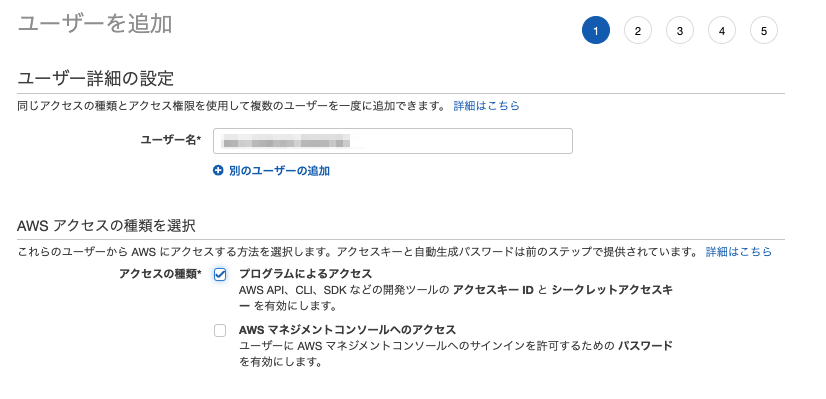

権限は `AmazonEC2FullAccess` と `AWSCloudFormationFullAccess` を想定しています。

正しくアクセス情報が指定されているかどうかを、`describe-vpcs`により確認します。**以下のコマンド実行がエラーとなる場合、`aws configure`が正しくなされていない可能性があります。**

In [2]:
import json
import sys

vpc_result = !aws ec2 describe-vpcs
try:
    vpcs = json.loads('\n'.join(vpc_result))['Vpcs']
    print('{} VPCs exist'.format(len(vpcs)))
except:
    print(vpc_result)
    raise sys.exc_info()

2 VPCs exist


本Notebookは、デモ用VPCとして、1つのVPCを追加します。

また、CloudFormationを利用してVPCやその他のリソースの準備を行います。CloudFormationのStackを1つ作成しますので、**本VMが不要になったら削除**してください。

In [3]:
stacks_result = !aws cloudformation list-stacks
try:
    stacks = json.loads('\n'.join(stacks_result))['StackSummaries']
    print('{} Stacks exist'.format(len(stacks)))
except:
    print(stacks_result)
    raise sys.exc_info()

6 Stacks exist


# リソースの定義



## CloudFormationのStack名

本Notebookが作成するリソースを管理するための CloudFormationのスタック名を設定してください。

In [4]:
cloudformation_stack_name = 'ophubtest0001'
cloudformation_stack_name

'ophubtest0001'

## イメージのID

イメージは CentOS 7を前提とする。

In [5]:
# CentOS 7
# ap-northeast-1を使用する場合
image_id = 'ami-06a46da680048c8ae'
# us-west-2 (オレゴン) を使用する場合
#image_id = 'ami-0bc06212a56393ee1'

## Keypairの準備

使用するキーペア名を設定します。

In [6]:
resource_prefix = 'ophubtest'
resource_prefix

'ophubtest'

以下のセルは、誤ってRun Allでまとめ実行した際に先に進まないように設定しています。
これまでのセル実行が問題なければ、以下のコードセルを選択してFreezeボタンを押してFreezeして先に進めてください。

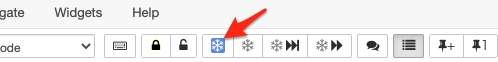

In [7]:
# ここまでのパラメータを確認したら本セルはFreezeして先に進める。
assert False

AssertionError: 

In [8]:
hostname = !hostname
keypair_name = '{}-{}'.format(resource_prefix, hostname[0])
keypair_name

'ophubtest-fadef2b73d71'

本Notebookはインスタンスとの接続のために、 `~/.ssh/ansible_id_rsa` と言う名前の秘密鍵ファイルを生成します。
Notebook環境の `/home/jovyan` をホストディレクトリにマウントするなどして永続化していないと、この秘密鍵もコンテナの削除とともに消えますのでご注意ください。

> デモ用途なのでPassphraseなしで作っています。実際にはPassphraseをつけて、ssh-agentで鍵の取り回しをしています。

In [9]:
import os
ssh_keypath = os.path.expanduser('~/.ssh')
if not os.path.exists(os.path.join(ssh_keypath, 'ansible_id_rsa')):
    !ssh-keygen -t rsa -b 2048 -C ansible -f {ssh_keypath}/ansible_id_rsa -P ''
!cat {ssh_keypath}/ansible_id_rsa.pub

Generating public/private rsa key pair.
Created directory '/home/jovyan/.ssh'.
Your identification has been saved in /home/jovyan/.ssh/ansible_id_rsa
Your public key has been saved in /home/jovyan/.ssh/ansible_id_rsa.pub
The key fingerprint is:
SHA256:41yloC9fA9Z2f0DE66JdGk5J20+FU8z2gxXhnJGUxGU ansible
The key's randomart image is:
+---[RSA 2048]----+
|             .=OE|
|             .+*B|
|        .   . +O.|
|       . o o.o+.o|
|      . S =..=..o|
|       = = .*.+..|
|      . + o= =.o.|
|       o ...+  ..|
|        .        |
+----[SHA256]-----+
ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQDJyfxPai4xpYsxkf9b6noIRRvViARm4cafg+OtERME1X8BoiPY2PoPC/ATb5/F08OMBvbXUw3ShkSQr+S9az0ZgQAukxudLIdhbDzRg4zIZolHgYHRwe+nFlUFmnHXvk48PTYW4PMpuC7c+1WBFQwmwEgP6/VzZ1R/1Sdi9iefkRqhCeAUnz98I5i4YHbXbCFDx9WTW48AqWTwRGvK6rjdbNZw20+gQ/DjTbWhK9ty6FN++f5W9CgwkMdBr0m907+lKbD/RHSXvlxYQrE4NfZRiAZ7DTKtAjrot1aLLQcwdm2bBXE9oVJnk+FLxg9xugnQZGpzTsPxR2Dkpbo74JYp ansible


現在のキーの一覧を確認しておきます。

In [10]:
import json
result = !aws ec2 describe-key-pairs
keypairs = json.loads('\n'.join(result))['KeyPairs']
print('{} keys'.format(len(keypairs)))

15 keys


本Notebookは設定された resource_prefix 変数と hostname を使ってキーペア名を決定します。同一名称のキーペア名があれば特に何もしません。

In [11]:
if keypair_name not in [k['KeyName'] for k in keypairs]:
    !aws ec2 import-key-pair --key-name {keypair_name} --public-key-material file://{ssh_keypath}/ansible_id_rsa.pub

{
    "KeyFingerprint": "4e:ba:a0:f9:73:2c:07:e5:73:5b:2b:5d:15:53:1a:8d",
    "KeyName": "ophubtest-fadef2b73d71",
    "KeyPairId": "key-07aee6cbcac08f85c"
}


# CloudFormation Stack作成

## Templateの定義

In [12]:
import tempfile
work_dir = tempfile.mkdtemp()
work_dir

'/tmp/tmpxjptr78b'

In [13]:
%%writefile {work_dir}/template.yml
AWSTemplateFormatVersion: "2010-09-09"
Description: 'A template for OperationHub(DEMO)'
Parameters:
  KeyName:
    Type: String
        
  ImageId:
    Type: String

Resources:
  VPC:
    Type: "AWS::EC2::VPC"
    Properties:
      CidrBlock: 10.1.0.0/16
      EnableDnsSupport: true
      EnableDnsHostnames: true
      Tags:
      - Key: Name
        Value:  !Join ['', [!Ref "AWS::StackName", "-VPC" ]]
            
  InternetGateway:
    Type: "AWS::EC2::InternetGateway"
    DependsOn: VPC
        
  AttachGateway:
    Type: "AWS::EC2::VPCGatewayAttachment"
    Properties:
      VpcId: !Ref VPC
      InternetGatewayId: !Ref InternetGateway
        
  OpHubSubnet:
    Type: AWS::EC2::Subnet
    Properties:
      VpcId: !Ref VPC
      CidrBlock: 10.1.1.0/24
      AvailabilityZone: !Select [ 0, !GetAZs ]    # Get the first AZ in the list       
      Tags:
      - Key: Name
        Value: !Sub ${AWS::StackName}-OpHub
                
  OpHubPublicRouteTable:
    Type: AWS::EC2::RouteTable
    Properties:
      VpcId: !Ref VPC
      Tags:
      - Key: Name
        Value: OpHubPublic

  OpHubRoute1:
    Type: AWS::EC2::Route
    DependsOn: AttachGateway
    Properties:
      RouteTableId: !Ref OpHubPublicRouteTable
      DestinationCidrBlock: 0.0.0.0/0
      GatewayId: !Ref InternetGateway  
        
  OpHubPublicRouteTableAssociation:
    Type: AWS::EC2::SubnetRouteTableAssociation
    Properties:
      SubnetId: !Ref OpHubSubnet
      RouteTableId: !Ref OpHubPublicRouteTable
        
  OpHubSecurityGroup:
    Type: AWS::EC2::SecurityGroup
    Properties:
      GroupDescription: security group for OperationHub
      VpcId: !Ref VPC
      Tags:
      - Key: Name
        Value: !Sub ${AWS::StackName}-OpHubSG

  OpHubEIP:
    Type: AWS::EC2::EIP
    Properties:
      InstanceId: !Ref OpHubInstance

  OpHubInstance:
    Type: "AWS::EC2::Instance"
    Properties: 
      ImageId: !Ref ImageId
      InstanceType: t2.medium
      KeyName: !Ref KeyName
      SecurityGroupIds:
        - !Ref OpHubSecurityGroup
      SubnetId: !Ref OpHubSubnet
      Tags:
      - Key: Name
        Value: !Sub ${AWS::StackName}-OpHub
      BlockDeviceMappings:
        - DeviceName: /dev/sda1
          Ebs:
            VolumeSize: 50
            DeleteOnTermination: true

Outputs:
  OpHubInstanceId:
    Value: !Ref OpHubInstance

  OpHubIP:
    Value: !Ref OpHubEIP

  OpHubVPC:
    Value: !Ref VPC

  OpHubSubnet:
    Value: !Ref OpHubSubnet

  OpHubSecurityGroup:
    Value: !Ref OpHubSecurityGroup

Writing /tmp/tmpxjptr78b/template.yml


## Stackの作成

Cloud FormationのStackを作成します。

In [14]:
stack_result = !aws cloudformation create-stack --stack-name {cloudformation_stack_name} \
    --parameters ParameterKey=KeyName,ParameterValue={keypair_name} ParameterKey=ImageId,ParameterValue={image_id} \
    --template-body file://{work_dir}/template.yml
try:
    stack_id = json.loads('\n'.join(stack_result))['StackId']
    print('StackId', stack_id)
except:
    print(stack_result)
    raise sys.exc_info()

StackId arn:aws:cloudformation:ap-northeast-1:274050600818:stack/ophubtest0001/7c42ab60-d159-11ea-a61b-0e0e3248afe0


以下のセルの実行結果に表示されるURLをクリックして、作成状況を確認してください。ステータスがCREATE_COMPLETEとなれば、Stackの作成は成功です。

In [15]:
import urllib.parse
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/cloudformation/home#/stacks/stackinfo?stackId={stack_id}'.format(region=regions[0], stack_id=urllib.parse.quote(stack_id)))

https://ap-northeast-1.console.aws.amazon.com/cloudformation/home#/stacks/stackinfo?stackId=arn%3Aaws%3Acloudformation%3Aap-northeast-1%3A274050600818%3Astack/ophubtest0001/7c42ab60-d159-11ea-a61b-0e0e3248afe0


**ステータスがCREATE_COMPLETEに変化したことを確認**したら、以下のセルを実行してください。

> 以下のセルは、Stack作成中の場合はエラーとなります。

In [17]:
describe_stack_result = !aws cloudformation describe-stacks --stack-name {stack_id}
stack_desc = json.loads(''.join(describe_stack_result))['Stacks'][0]
assert stack_desc['StackStatus'] == 'CREATE_COMPLETE', stack_desc['StackStatus']

## Security Groupの変更

CloudFormationにより、VMインスタンスが起動したようなので、Notebook環境から疎通確認をする。VMインスタンスのSecurity Groupは**デフォルトではどこからも接続を受け入れないようにしている**ので以下のURLから設定変更する。

AnsibleでのVM操作にはSSH(TCPポート22)を使用する。このJupyter Notebook環境からVMへのSSHアクセスを許可するよう適切なポートおよびアクセス元IPアドレスを指定する。**インバウンドルールを編集**ボタンを選択して、以下のようなルールを追加する。

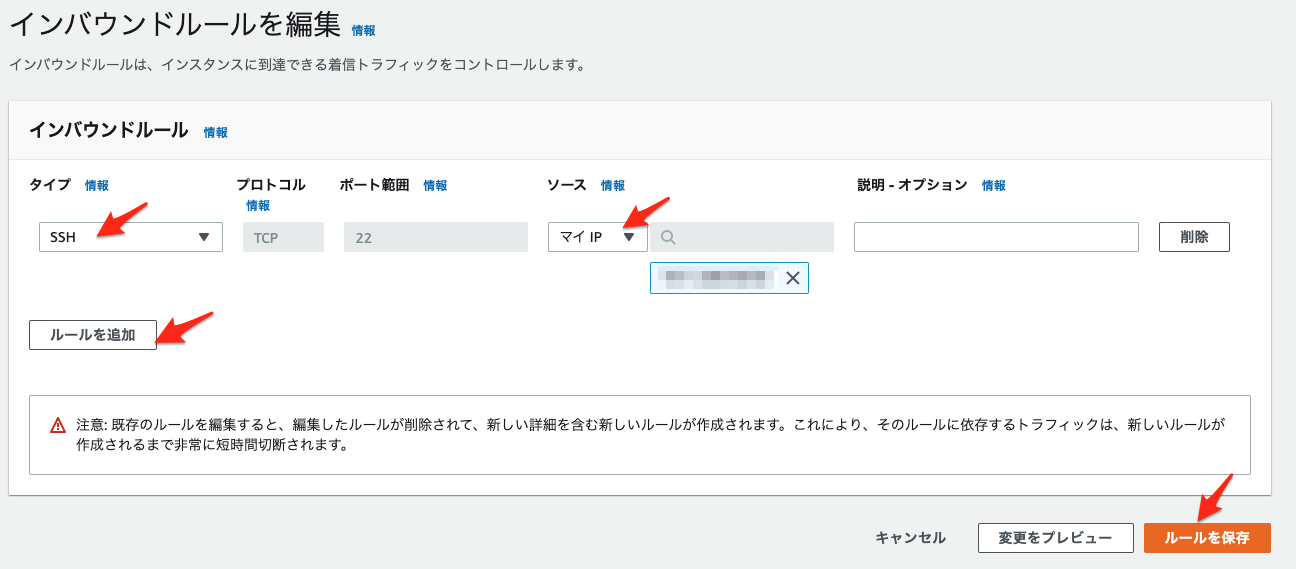

参考までに、このJupyter Notebookのアクセス元IPアドレスは以下となる。

> IPアドレスの取得に https://ifconfig.co サービスを使用します。

In [18]:
import requests
resp = requests.get('https://ifconfig.co/json')
resp.raise_for_status()
print(resp.json()['ip'])

122.214.152.139


Security GroupのIDはStackのOutputsに記録されている。

In [19]:
stack_desc['Outputs']

[{'OutputKey': 'OpHubSubnet', 'OutputValue': 'subnet-0b58e3ac4ac9d27a2'},
 {'OutputKey': 'OpHubIP', 'OutputValue': '54.249.212.94'},
 {'OutputKey': 'OpHubSecurityGroup', 'OutputValue': 'sg-089504a8e15444a5c'},
 {'OutputKey': 'OpHubVPC', 'OutputValue': 'vpc-03b581662714aebd2'},
 {'OutputKey': 'OpHubInstanceId', 'OutputValue': 'i-0f86624c90a8e31c4'}]

In [20]:
security_group_id = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'OpHubSecurityGroup'][0]
security_group_id

'sg-089504a8e15444a5c'

In [21]:
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/ec2/v2/home?region={region}#SecurityGroup:groupId={security_group_id}'.format(region=regions[0], security_group_id=security_group_id))

https://ap-northeast-1.console.aws.amazon.com/ec2/v2/home?region=ap-northeast-1#SecurityGroup:groupId=sg-089504a8e15444a5c


In [23]:
# セキュリティグループにSSHに関する許可が含まれていれば先に進める
sg_result = !aws ec2 describe-security-groups --group-ids {security_group_id}
sg_desc = json.loads(''.join(sg_result))['SecurityGroups'][0]

assert 'IpPermissions' in sg_desc and any([ipperm['IpProtocol'] == 'tcp' and ipperm['ToPort'] <= 22 and 22 <= ipperm['FromPort'] for ipperm in sg_desc['IpPermissions']]), sg_desc['IpPermissions']

# Ansibleユーザの設定

In [24]:
default_username = 'centos'
default_username

'centos'

In [25]:
import os

with open(os.path.join(work_dir, 'hosts'), 'w') as f:
    host = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'OpHubIP'][0]
    f.write('{host} ansible_ssh_user={user} ansible_ssh_private_key_file={pkpath}\n'.format(host=host,
                                                                                          user=default_username,
                                                                                          pkpath='~/.ssh/ansible_id_rsa'))

!cat {work_dir}/hosts

54.249.212.94 ansible_ssh_user=centos ansible_ssh_private_key_file=~/.ssh/ansible_id_rsa


In [26]:
%%writefile {work_dir}/init-password-aws
#!/usr/bin/expect

set host [lindex $argv 0]
set key [lindex $argv 1]
set username [lindex $argv 2]

spawn env LANG=C ssh -i $key "${username}\@${host}"

expect {
    -glob "(yes/no/*)?" {
        send "yes\n"
        exp_continue
    }
}

exit 0



Writing /tmp/tmpxjptr78b/init-password-aws


In [27]:
import time

# VMのsshserverが落ち着くまで待つ...
time.sleep(30)

In [28]:
target_hostname = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'OpHubIP'][0]
!ssh-keygen -R {target_hostname} || exit 0
!expect {work_dir}/init-password-aws {target_hostname} ~/.ssh/ansible_id_rsa {default_username}

do_known_hosts: hostkeys_foreach failed: No such file or directory
spawn env LANG=C ssh -i /home/jovyan/.ssh/ansible_id_rsa centos@54.249.212.94
The authenticity of host '54.249.212.94 (54.249.212.94)' can't be established.
ECDSA key fingerprint is SHA256:SqF89f7OvGzOWLslV52iJkWUtmcAo5oNh0HtJp96gLk.
Are you sure you want to continue connecting (yes/no/[fingerprint])? yes
]0;centos@ip-10-1-1-189:~[centos@ip-10-1-1-189 ~]$ 

In [29]:
!ansible -m ping -i {work_dir}/hosts all

54.249.212.94 | SUCCESS => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": false,
    "ping": "pong"
}


上記のセルがエラーとなる場合は、以下のように `-vvvv` オプションをつけてどんなメッセージが流れているかを確認してみましょう。

> !ansible -vvvv -m ping -i {work_dir}/hosts all
>
> Connection timed out の場合は、先のSecurity Groupがあっているかを確認すると良い...

OK。

# Inventoryへの追記

さてこれでVMが確保できました。Inventoryにhost情報を追記して、Ansibleからアクセスできるようにしましょう。


In [30]:
if not os.path.exists('./hosts'):
    !touch ./hosts
!cp ./hosts {work_dir}/hosts-backup

Inventoryに記述する例は以下のような感じ...

In [31]:
print('[{}]'.format(cloudformation_stack_name))
!cat {work_dir}/hosts

[ophubtest0001]
54.249.212.94 ansible_ssh_user=centos ansible_ssh_private_key_file=~/.ssh/ansible_id_rsa


Inventoryを編集する。
1. [このNotebookがあるディレクトリ](/tree/) と同じ階層に `hosts` というファイルがあるので、これをクリックしてエディタを開く
2. 上記セルの出力 **2行分(スタック名とIPアドレスを含む)** をコピー＆ペーストする

`hosts`の変更差分を控えておく。

In [33]:
# ./hostsに変更を加えるとこのセルを通過できる
! ! diff -u {work_dir}/hosts-backup ./hosts

--- /tmp/tmpxjptr78b/hosts-backup	2020-07-29 05:12:04.803152000 +0000
+++ ./hosts	2020-07-29 05:12:24.784152000 +0000
@@ -0,0 +1,2 @@
+[ophubtest0001]
+54.249.212.94 ansible_ssh_user=centos ansible_ssh_private_key_file=~/.ssh/ansible_id_rsa
\ No newline at end of file


`hosts` ファイルのテストを実施する。

Ansibleに上記で設定したグループ名を与えてpingモジュールを実行する。

In [34]:
target_group = '-i ./hosts {}'.format(cloudformation_stack_name)
target_group

'-i ./hosts ophubtest0001'

In [35]:
!ansible -m ping {target_group}

54.249.212.94 | SUCCESS => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": false,
    "ping": "pong"
}


これでVMの準備は完了です！

# About: OperationHubのインストール

# 各種設定

## インストール対象VM

In [36]:
ophub_dir = '/opt/ophub'

!ansible -b -m file -a 'path={ophub_dir} state=directory' {target_group}

54.249.212.94 | CHANGED => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": true,
    "gid": 0,
    "group": "root",
    "mode": "0755",
    "owner": "root",
    "path": "/opt/ophub",
    "secontext": "unconfined_u:object_r:usr_t:s0",
    "size": 6,
    "state": "directory",
    "uid": 0
}


対象ホストはCentOS 7 がデプロイされているものとします。

In [37]:
!ansible -a 'cat /etc/centos-release' {target_group}

54.249.212.94 | CHANGED | rc=0 >>
CentOS Linux release 7.7.1908 (Core)


## ドメイン名設定

`server_name`変数に、OperationHubを動作させるホストのドメイン名を設定する。

ここではデモ用と限定して、AWSで確保されたインスタンスである前提で設定する。

In [38]:
server_name = target_hostname
assert server_name is not None, 'Unexpected result: {}'.format(''.join(ping_result))
server_name

'54.249.212.94'

## サーバ証明書設定

`cert_file`, `key_file` 変数に、サーバ証明書と秘密鍵のパス(Notebookサーバ上のパス)を指定する。

ここではデモ用と限定して、自己署名の証明書を設定する。

In [39]:
import os

key_file = '.cert-20200702/demo.key'

!mkdir -p {os.path.split(key_file)[0]}
!openssl genrsa 2048 > {key_file}

Generating RSA private key, 2048 bit long modulus (2 primes)
....................................................................................+++++
....................................................................................................+++++
e is 65537 (0x010001)


In [40]:
cert_file = '.cert-20200702/demo.cer'

!openssl req -new -subj "/C=JP/CN={server_name}" -x509 -days 31 -key {key_file} -sha512 -out {cert_file}

内容を確認する。

In [41]:
!openssl x509 -in {cert_file} -noout -text

Certificate:
    Data:
        Version: 3 (0x2)
        Serial Number:
            25:91:4b:23:b0:2f:b2:ef:c1:39:7f:6d:0f:1f:66:25:7e:65:90:07
        Signature Algorithm: sha512WithRSAEncryption
        Issuer: C = JP, CN = 54.249.212.94
        Validity
            Not Before: Jul 29 05:12:43 2020 GMT
            Not After : Aug 29 05:12:43 2020 GMT
        Subject: C = JP, CN = 54.249.212.94
        Subject Public Key Info:
            Public Key Algorithm: rsaEncryption
                RSA Public-Key: (2048 bit)
                Modulus:
                    00:ca:b4:72:dd:a5:5d:26:fd:c8:8b:ce:92:d0:4d:
                    1f:ab:1a:74:cf:bf:35:b1:8b:81:d1:51:e4:75:87:
                    44:50:31:bf:92:63:4b:0c:96:94:27:33:33:e6:64:
                    4b:99:9e:23:ab:da:78:e8:66:59:24:05:6a:e5:01:
                    e8:34:0e:d6:d1:a4:ba:11:47:8f:39:8f:e5:cc:dc:
                    9a:40:80:4f:52:b8:74:4e:02:b8:35:8f:3c:b5:95:
                    b1:3a:36:43:f0:ef:be:22:f0:18:c1:6c:b

## 管理者ユーザ設定

最初に作る管理者ユーザのユーザ名及びパスワードを指定する。

PasswordはNotebookに残らないよう、getpassを使用して入力する。
パスワード入力用のフィールドが現れるので、新規作成する管理者ユーザのパスワードを入力し、ENTERを押す。

In [42]:
import getpass

admin_username = 'ohadmin'
admin_password = getpass.getpass()

········


In [43]:
# ユーザ名とパスワードを確認したらFreezeして先に進める
assert False

AssertionError: 

# インストールの実施

https://github.com/NII-cloud-operation/OperationHub に従いながら...

## Step 1: Download OperationHub files

まず、対象のホストにgitをインストールする。

In [45]:
!ansible -b -m yum -a 'name=git' {target_group}

54.249.212.94 | CHANGED => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": true,
    "changes": {
        "installed": [
            "git"
        ]
    },
    "msg": "warning: /var/cache/yum/x86_64/7/base/packages/perl-Carp-1.26-244.el7.noarch.rpm: Header V3 RSA/SHA256 Signature, key ID f4a80eb5: NOKEY\nImporting GPG key 0xF4A80EB5:\n Userid     : \"CentOS-7 Key (CentOS 7 Official Signing Key) <security@centos.org>\"\n Fingerprint: 6341 ab27 53d7 8a78 a7c2 7bb1 24c6 a8a7 f4a8 0eb5\n Package    : centos-release-7-7.1908.0.el7.centos.x86_64 (installed)\n From       : /etc/pki/rpm-gpg/RPM-GPG-KEY-CentOS-7\n",
    "rc": 0,
    "results": [
        "Loaded plugins: fastestmirror\nLoading mirror speeds from cached hostfile\n * base: d36uatko69830t.cloudfront.net\n * extras: d36uatko69830t.cloudfront.net\n * updates: d36uatko69830t.cloudfront.net\nResolving Dependencies\n--> Running transaction check\n---> Package git.x86_64 0:1.8.3.1

リポジトリのcloneはAnsible gitモジュールを使う。

In [46]:
!ansible -b -m git -a 'repo=https://github.com/NII-cloud-operation/OperationHub.git dest={ophub_dir}' {target_group}

54.249.212.94 | CHANGED => {
    "after": "50d8d88f410a618c28371cd5fee6b5cc00641683",
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "before": null,
    "changed": true
}


cloneされたバージョンを押さえておこう... あとでうまく動作しなくなった！と言う時に良いヒントとなります。

In [47]:
!ansible -a 'ls -la {ophub_dir}' {target_group}
!ansible -a 'chdir={ophub_dir} git log -1' {target_group}

54.249.212.94 | CHANGED | rc=0 >>
total 48
drwxr-xr-x. 7 root root   256 Jul 29 05:18 .
drwxr-xr-x. 3 root root    19 Jul 29 05:12 ..
-rw-r--r--. 1 root root  3127 Jul 29 05:18 docker-compose.yml
drwxr-xr-x. 2 root root    59 Jul 29 05:18 docs
-rw-r--r--. 1 root root   566 Jul 29 05:18 .env.sample
drwxr-xr-x. 8 root root   180 Jul 29 05:18 .git
-rw-r--r--. 1 root root    14 Jul 29 05:18 .gitignore
drwxr-xr-x. 2 root root   126 Jul 29 05:18 host-service
drwxr-xr-x. 4 root root    37 Jul 29 05:18 images
-rwxr-xr-x. 1 root root   598 Jul 29 05:18 install-docker.sh
-rwxr-xr-x. 1 root root   972 Jul 29 05:18 install-host-services.sh
-rw-r--r--. 1 root root 10321 Jul 29 05:18 jupyterhub-logo.png
-rw-r--r--. 1 root root  1534 Jul 29 05:18 LICENSE
drwxr-xr-x. 2 root root    33 Jul 29 05:18 nginx
-rw-r--r--. 1 root root  8357 Jul 29 05:18 README.md
54.249.212.94 | CHANGED | rc=0 >>
commit 50d8d88f410a618c28371cd5fee6b5cc00641683
Author: nobu <n08u@acm.org>
Date:   Tue Jul 21 11:55:50 2020 +0900

##  Step 2: Install Docker Engine and docker-compose

Docker EngineとDocker Composeを対象ホストにインストールする。

In [48]:
!ansible -b -a 'chdir={ophub_dir} ./install-docker.sh' {target_group}

54.249.212.94 | CHANGED | rc=0 >>
Loaded plugins: fastestmirror
Loading mirror speeds from cached hostfile
 * base: d36uatko69830t.cloudfront.net
 * extras: d36uatko69830t.cloudfront.net
 * updates: d36uatko69830t.cloudfront.net
Resolving Dependencies
--> Running transaction check
---> Package device-mapper-persistent-data.x86_64 0:0.8.5-2.el7 will be installed
--> Processing Dependency: libaio.so.1(LIBAIO_0.4)(64bit) for package: device-mapper-persistent-data-0.8.5-2.el7.x86_64
--> Processing Dependency: libaio.so.1(LIBAIO_0.1)(64bit) for package: device-mapper-persistent-data-0.8.5-2.el7.x86_64
--> Processing Dependency: libaio.so.1()(64bit) for package: device-mapper-persistent-data-0.8.5-2.el7.x86_64
---> Package lvm2.x86_64 7:2.02.186-7.el7_8.2 will be installed
--> Processing Dependency: lvm2-libs = 7:2.02.186-7.el7_8.2 for package: 7:lvm2-2.02.186-7.el7_8.2.x86_64
--> Processing Dependency: liblvm2app.so.2.2(Base)(64bit) for package: 7:lvm2-2.02.186-7.el7_8.2.x86_64
--> Processi

## Step 3: Install the host services for OperationHub

OperationHubに必要なサービスを対象ホストにインストールする。

In [49]:
!ansible -b -a 'chdir={ophub_dir} ./install-host-services.sh' {target_group}

54.249.212.94 | CHANGED | rc=0 >>
Loaded plugins: fastestmirror
Loading mirror speeds from cached hostfile
 * base: d36uatko69830t.cloudfront.net
 * extras: d36uatko69830t.cloudfront.net
 * updates: d36uatko69830t.cloudfront.net
Resolving Dependencies
--> Running transaction check
---> Package epel-release.noarch 0:7-11 will be installed
--> Finished Dependency Resolution

Dependencies Resolved

 Package                Arch             Version         Repository        Size
Installing:
 epel-release           noarch           7-11            extras            15 k

Transaction Summary
Install  1 Package

Total download size: 15 k
Installed size: 24 k
Running transaction check
Running transaction test
Transaction test succeeded
Running transaction
  Installing : epel-release-7-11.noarch                                     1/1 
  Verifying  : epel-release-7-11.noarch                                     1/1 

Installed:
  epel-release.noarch 0:7-11                                         

## Step 4: Setting domain name

DNS名を設定します。

In [50]:
import tempfile

work_dir = tempfile.mkdtemp()
work_dir

'/tmp/tmpt2r8bh85'

In [51]:
!ansible -b -a 'chdir={ophub_dir} cat .env.sample' {target_group}

54.249.212.94 | CHANGED | rc=0 >>
# Server Name for nginx TLS communication (reverse proxy)
SERVER_NAME=example.com

# JupyterHub single-user docker image
SINGLE_USER_IMAGE=niicloudoperation/notebook

# Configuration for culling idle servers
## Enable culling
CULL_SERVER=yes

## The idle timeout (in seconds) for culling server
CULL_SERVER_IDLE_TIMEOUT=300

## The maximum age (in seconds) of servers that should be culled even if they are active
CULL_SERVER_MAX_AGE=86400

## The interval (in seconds) for checking for idle servers to cull
CULL_SERVER_EVERY=60

# Enable Debug Logging
# DEBUG=yes


サンプル環境はawscliを含むイメージを用意する。

In [52]:
image_name = 'niicloudoperation/test-notebook'
image_name

'niicloudoperation/test-notebook'

In [53]:
with open(os.path.join(work_dir, '.env'), 'w') as f:
    f.write('''# Server Name for nginx TLS communication (reverse proxy)
SERVER_NAME={server_name}

# JupyterHub single-user docker image
SINGLE_USER_IMAGE={image_name}

# Configuration for culling idle servers
## Enable culling
CULL_SERVER=yes

## The idle timeout (in seconds) for culling server
CULL_SERVER_IDLE_TIMEOUT=300

## The maximum age (in seconds) of servers that should be culled even if they are active
CULL_SERVER_MAX_AGE=86400

## The interval (in seconds) for checking for idle servers to cull
CULL_SERVER_EVERY=60

# Enable Debug Logging
# DEBUG=yes
'''.format(**locals()))

!cat {work_dir}/.env

# Server Name for nginx TLS communication (reverse proxy)
SERVER_NAME=54.249.212.94

# JupyterHub single-user docker image
SINGLE_USER_IMAGE=niicloudoperation/test-notebook

# Configuration for culling idle servers
## Enable culling
CULL_SERVER=yes

## The idle timeout (in seconds) for culling server
CULL_SERVER_IDLE_TIMEOUT=300

## The maximum age (in seconds) of servers that should be culled even if they are active
CULL_SERVER_MAX_AGE=86400

## The interval (in seconds) for checking for idle servers to cull
CULL_SERVER_EVERY=60

# Enable Debug Logging
# DEBUG=yes


In [54]:
!ansible -b -m copy -a 'src={work_dir}/.env dest={ophub_dir}/.env' {target_group}

54.249.212.94 | CHANGED => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": true,
    "checksum": "77c7b8406b199ce8f6d22d7b13389f54c96dbc61",
    "dest": "/opt/ophub/.env",
    "gid": 0,
    "group": "root",
    "md5sum": "0ca8e8b7dd917b21faefdae44d196273",
    "mode": "0644",
    "owner": "root",
    "secontext": "system_u:object_r:usr_t:s0",
    "size": 572,
    "src": "/home/centos/.ansible/tmp/ansible-tmp-1596000012.792253-337-258655366479097/source",
    "state": "file",
    "uid": 0
}


## Step 5: Install TLS certificate and key

In [55]:
!ansible -b -m file -a 'path={ophub_dir}/cert state=directory' {target_group}
!ansible -b -m copy -a 'src={cert_file} dest={ophub_dir}/cert/server.cer' {target_group}
!ansible -b -m copy -a 'src={key_file} dest={ophub_dir}/cert/server.key' {target_group}

54.249.212.94 | CHANGED => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": true,
    "gid": 0,
    "group": "root",
    "mode": "0755",
    "owner": "root",
    "path": "/opt/ophub/cert",
    "secontext": "unconfined_u:object_r:usr_t:s0",
    "size": 6,
    "state": "directory",
    "uid": 0
}
54.249.212.94 | CHANGED => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": true,
    "checksum": "40fcb5123226129dba9f95703bccbf9f0924a1c6",
    "dest": "/opt/ophub/cert/server.cer",
    "gid": 0,
    "group": "root",
    "md5sum": "aa9fc8c95fbd0ee0ffaa221667006592",
    "mode": "0644",
    "owner": "root",
    "secontext": "system_u:object_r:usr_t:s0",
    "size": 1159,
    "src": "/home/centos/.ansible/tmp/ansible-tmp-1596000019.0795798-378-15497324234693/source",
    "state": "file",
    "uid": 0
}
54.249.212.94 | CHANGED => {
    "ansible_facts": {
        "discovered_interprete

## Step 6: Setting JupyterHub administrator

最初の管理者ユーザを設定する。ユーザ名とパスワードは 各種設定 - 管理者ユーザ設定 で実施されているものとする。

In [56]:
from passlib.hash import sha512_crypt

# 参考: https://docs.ansible.com/ansible/faq.html#how-do-i-generate-encrypted-passwords-for-the-user-module
!ansible -b -m user -a 'name={admin_username} password={sha512_crypt.using(rounds=5000).hash(admin_password)}' {target_group}

54.249.212.94 | CHANGED => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": true,
    "comment": "",
    "create_home": true,
    "group": 1001,
    "home": "/home/john",
    "name": "john",
    "password": "NOT_LOGGING_PASSWORD",
    "shell": "/bin/bash",
    "state": "present",
    "system": false,
    "uid": 1001
}


In [57]:
!ansible -b -a 'usermod -aG wheel {admin_username}' {target_group}

54.249.212.94 | CHANGED | rc=0 >>



## ユーザ用イメージの準備

ユーザ用イメージをあらかじめPullしておく。

In [58]:
!ansible -b -a 'docker pull niicloudoperation/notebook' {target_group}

54.249.212.94 | CHANGED | rc=0 >>
Using default tag: latest
latest: Pulling from niicloudoperation/notebook
a4a2a29f9ba4: Pulling fs layer
127c9761dcba: Pulling fs layer
d13bf203e905: Pulling fs layer
4039240d2e0b: Pulling fs layer
16baf7565818: Pulling fs layer
8d4b4e3fa8e0: Pulling fs layer
9b5cd6dc7e5c: Pulling fs layer
2fadbbcf7ce9: Pulling fs layer
0cd922ae20a5: Pulling fs layer
f5e764406ee1: Pulling fs layer
011a76fea054: Pulling fs layer
1b59e5a8c825: Pulling fs layer
3f4f1174f174: Pulling fs layer
430109c788cf: Pulling fs layer
ef6b34bbbee3: Pulling fs layer
edc996f5b41a: Pulling fs layer
5c69830ff598: Pulling fs layer
17932824baa9: Pulling fs layer
25c98e42fcbd: Pulling fs layer
b6f59bca789a: Pulling fs layer
9bce9285d933: Pulling fs layer
3874c2ef81bb: Pulling fs layer
00d8f31730c1: Pulling fs layer
fc31249c0b8a: Pulling fs layer
bcb1f8f6229a: Pulling fs layer
7fa8ca213bf8: Pulling fs layer
12d650a1e79e: Pulling fs layer
7aa1c82b863f: Pulling fs layer
3cc68da333df: Pulling fs

In [59]:
%%writefile {work_dir}/Dockerfile
FROM niicloudoperation/notebook

USER root

# Installing awscli
RUN conda install --quiet --yes awscli passlib && conda clean --all -f -y
RUN apt-get update && apt-get install -y expect && \
    apt-get clean && rm -rf /var/lib/apt/lists/*

USER $NB_USER

Writing /tmp/tmpt2r8bh85/Dockerfile


In [60]:
!ansible -b -m file -a 'path={ophub_dir}/sample state=directory' {target_group}
!ansible -b -m copy -a 'src={work_dir}/Dockerfile dest={ophub_dir}/sample/Dockerfile' {target_group}

54.249.212.94 | CHANGED => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": true,
    "gid": 0,
    "group": "root",
    "mode": "0755",
    "owner": "root",
    "path": "/opt/ophub/sample",
    "secontext": "unconfined_u:object_r:usr_t:s0",
    "size": 6,
    "state": "directory",
    "uid": 0
}
54.249.212.94 | CHANGED => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": true,
    "checksum": "753a37a511d2c718475a18a4a3993347f7e740c7",
    "dest": "/opt/ophub/sample/Dockerfile",
    "gid": 0,
    "group": "root",
    "md5sum": "2461e7d4775949e60ea631463eb2e3b4",
    "mode": "0644",
    "owner": "root",
    "secontext": "system_u:object_r:usr_t:s0",
    "size": 255,
    "src": "/home/centos/.ansible/tmp/ansible-tmp-1596000175.6563041-494-273309246692178/source",
    "state": "file",
    "uid": 0
}


In [61]:
!ansible -b -a 'chdir={ophub_dir}/sample docker build -t {image_name} .' {target_group}

54.249.212.94 | CHANGED | rc=0 >>

Step 1/5 : FROM niicloudoperation/notebook
 ---> b0450299a1fb
Step 2/5 : USER root
 ---> Running in ee850ecc1284
Removing intermediate container ee850ecc1284
 ---> d6000d103382
Step 3/5 : RUN conda install --quiet --yes awscli passlib && conda clean --all -f -y
 ---> Running in 7ede958501ff
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - awscli
    - passlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    argon2_cffi-19.1.0         |py38h516909a_1000          52 KB  conda-forge
    awscli-1.18.107            |   py38h32f6830_0         1.7 MB  conda-forge
    bcrypt-3.1.7               |   py38h1e0a361_1          43 KB  conda-forge
    botocore-1.17.30           |     pyh9f0ad1d_0         4.0 MB  conda-forge
    colorama-0.4.3             |             py_0          17 KB  

## Step 7: Starting OperationHub

関連イメージをビルドする。

In [62]:
!ansible -b -a 'chdir={ophub_dir} docker-compose build' {target_group}

54.249.212.94 | CHANGED | rc=0 >>
Step 1/12 : FROM jupyterhub/jupyterhub:1.0.0
1.0.0: Pulling from jupyterhub/jupyterhub
Digest: sha256:2bd3ea9602f61aa719a4f9458c64966c9cd839145cec08f0f1980124595dbd69
Status: Downloaded newer image for jupyterhub/jupyterhub:1.0.0
 ---> 64d82994fd55
Step 2/12 : RUN apt-get update && apt-get install -y make && apt-get autoclean && apt-get clean && apt-get autoremove
 ---> Running in 56ddc02bd4d6
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1032 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [874 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [9555 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [99.9 

サービスを起動する。

In [63]:
!ansible -b -a 'chdir={ophub_dir} docker-compose up -d' {target_group}

54.249.212.94 | CHANGED | rc=0 >>
Creating network "jupyterhub_backend" with driver "bridge"





# テストコンテンツの配備

体験コンテンツを管理者アカウントのディレクトリに配置する。

In [64]:
with open(os.path.join(work_dir, 'cloudformation-stack.json'), 'w') as f:
    f.write(json.dumps(stack_desc['Outputs']))

!ansible -b -m copy -a 'src={work_dir}/cloudformation-stack.json dest=/home/{admin_username}/ owner={admin_username} group={admin_username}' {target_group}
!ansible -b -m file -a 'path=/home/{admin_username}/notebooks state=directory owner={admin_username} group={admin_username}' {target_group}
!ansible -b -m copy -a 'src=./05_01_Elasticsearch構築手順への適用例 dest=/home/{admin_username}/notebooks/ owner={admin_username} group={admin_username}' {target_group}

54.249.212.94 | CHANGED => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": true,
    "checksum": "5bb58a9ed13bf4d0d36a62cdffcf263c508c3ed8",
    "dest": "/home/john/cloudformation-stack.json",
    "gid": 1001,
    "group": "john",
    "md5sum": "1e1d9ae163c098f02cb45382e0262c1e",
    "mode": "0644",
    "owner": "john",
    "secontext": "unconfined_u:object_r:user_home_t:s0",
    "size": 346,
    "src": "/home/centos/.ansible/tmp/ansible-tmp-1596000329.882028-569-280094983651149/source",
    "state": "file",
    "uid": 1001
}
54.249.212.94 | CHANGED => {
    "ansible_facts": {
        "discovered_interpreter_python": "/usr/bin/python"
    },
    "changed": true,
    "gid": 1001,
    "group": "john",
    "mode": "0755",
    "owner": "john",
    "path": "/home/john/notebooks",
    "secontext": "unconfined_u:object_r:user_home_t:s0",
    "size": 6,
    "state": "directory",
    "uid": 1001
}
54.249.212.94 | CHANGED => {
    "change

In [65]:
!ansible -b -m copy -a 'src=~/.aws dest=/home/{admin_username}/ owner={admin_username} group={admin_username}' {target_group}

54.249.212.94 | CHANGED => {
    "changed": true,
    "dest": "/home/john/",
    "src": "/home/jovyan/.aws"
}


# 動作確認

自身のPCからVMのHTTPS (TCP 443)を許可するように設定する。SSHの設定と同じ要領でOK。アクセス元IPアドレスは動作確認をするPCのものを指定すること。

In [66]:
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/ec2/v2/home?region={region}#SecurityGroup:groupId={security_group_id}'.format(region=regions[0], security_group_id=security_group_id))

https://ap-northeast-1.console.aws.amazon.com/ec2/v2/home?region=ap-northeast-1#SecurityGroup:groupId=sg-089504a8e15444a5c


In [68]:
# セキュリティグループにHTTPSに関する許可が含まれていれば先に進める
sg_result = !aws ec2 describe-security-groups --group-ids {security_group_id}
sg_desc = json.loads(''.join(sg_result))['SecurityGroups'][0]

assert 'IpPermissions' in sg_desc and any([ipperm['IpProtocol'] == 'tcp' and ipperm['ToPort'] <= 443 and 443 <= ipperm['FromPort'] for ipperm in sg_desc['IpPermissions']]), sg_desc['IpPermissions']

以下のURLにブラウザからアクセスする。

サーバ証明書に関する警告が出るので、適当なブラウザを使用し、例外設定して確認すること。ユーザ名とパスワードを求められたら、各種設定 の **管理者ユーザ設定** で設定したユーザ名及びパスワードでログインする。

> 下記のURLのアクセスがタイムアウトになる場合は、先のSecurity Groupで適切にHTTPSが許可されていない可能性が高い...

In [69]:
print('https://' + server_name)
print('  Username', admin_username)
print('  Password', '入力したもの')

https://54.249.212.94
  Username john
  Password 入力したもの


サービスの状態・ログは以下から確認することができます。

In [70]:
!ansible -b -a 'chdir={ophub_dir} docker-compose ps' {target_group}

54.249.212.94 | CHANGED | rc=0 >>
       Name                     Command               State               Ports            
-------------------------------------------------------------------------------------------
ophub_jupyterhub_1   jupyterhub                       Up      8000/tcp                     
ophub_proxy_1        /docker-entrypoint.sh /bin ...   Up      80/tcp, 0.0.0.0:443->8443/tcp


In [71]:
!ansible -b -a 'chdir={ophub_dir} docker-compose logs jupyterhub' {target_group}

54.249.212.94 | CHANGED | rc=0 >>
Attaching to ophub_jupyterhub_1
jupyterhub_1  | [I 2020-07-29 05:25:27.954 JupyterHub tracking_server:44] Writing server signature to /srv/jupyterhub/data/server_signature
jupyterhub_1  | [I 2020-07-29 05:25:27.983 JupyterHub app:2120] Using Authenticator: ophubauthenticator.OphubPAMAuthenticator
jupyterhub_1  | [I 2020-07-29 05:25:27.984 JupyterHub app:2120] Using Spawner: dockerspawner.dockerspawner.DockerSpawner-0.12.0dev
jupyterhub_1  | [I 2020-07-29 05:25:27.990 JupyterHub app:1302] Writing cookie_secret to /srv/jupyterhub/jupyterhub_cookie_secret
jupyterhub_1  | [I 2020-07-29 05:25:28.015 alembic.runtime.migration migration:130] Context impl SQLiteImpl.
jupyterhub_1  | [I 2020-07-29 05:25:28.016 alembic.runtime.migration migration:137] Will assume non-transactional DDL.
jupyterhub_1  | [I 2020-07-29 05:25:28.027 alembic.runtime.migration migration:356] Running stamp_revision  -> 4dc2d5a8c53c
jupyterhub_1  | [I 2020-07-29 05:25:28.103 JupyterHub p

# OperationHubを使ってみる

OperationHubに管理者ユーザでログインすると、 **05_01_Elasticsearch構築手順への適用例** というNotebookがあるはずです。

このNotebookを説明に従い実行すると、OperationHubのVPC内にElasticsearchを作り、操作を試してみることができます。ぜひ、試してみてください。

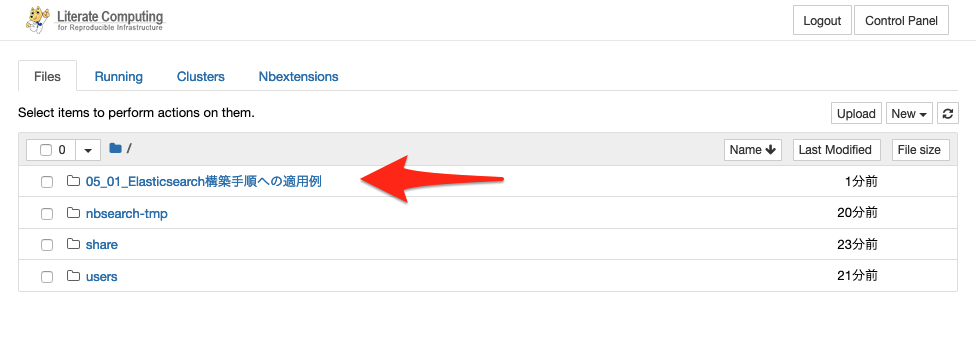

# (試用後)不要AWSリソースの削除

AWSのリソースはCloudFormationから管理できます。

このStackを削除すると、関連するリソースを削除することができます。

> Elasticsearchなど、クラスタ内にVMやSecurity Group等を作成した場合は、その作成したVMやSecurityGroupを削除したのち、Stackを削除してください。

In [72]:
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/cloudformation/home#/stacks/stackinfo?stackId={stack_id}'.format(region=regions[0], stack_id=urllib.parse.quote(stack_id)))

https://ap-northeast-1.console.aws.amazon.com/cloudformation/home#/stacks/stackinfo?stackId=arn%3Aaws%3Acloudformation%3Aap-northeast-1%3A274050600818%3Astack/ophubtest0001/7c42ab60-d159-11ea-a61b-0e0e3248afe0
